### Packages :

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
import random as r
from math import *
from numpy import linalg as LA
import os
import osmnx as ox

### Exemples :

In [2]:
Petersen = nx.petersen_graph()
C6 = nx.cycle_graph(6)
Biparti34 = nx.complete_bipartite_graph(3,4)

pos_bip34 = {0 : [-1,1], 1 : [0,1], 2 : [1, 1], 3 : [-1.5, -1], 4 : [-0.5, -1], 5 : [0.5, -1], 6 : [1.5, -1]}





def downloadVille(location,nom_fichier):
    base_filepath = "C:/Users/Dreyer Simon/Documents/Travail/5A/Stage de recherche/code python/data/"
    G = ox.graph_from_place(location, network_type="drive")
    G = rename_nodes(G)

    filepath = base_filepath + nom_fichier + ".graphml"
    ox.save_graphml(G, filepath)


def loadVille(nom_fichier):
    base_filepath = "C:/Users/Dreyer Simon/Documents/Travail/5A/Stage de recherche/code python/data/"
    filepath = base_filepath + nom_fichier + ".graphml"

    return ox.load_graphml(filepath)



Piedmont = loadVille("piemont")

### Fonctions utiles :

In [3]:
def recherche_dicho(table,rang):
    """Renvoie l'indice i tel que table[i-1] < rang <= table[i]"""
    if (rang <= table[0]):
        return 0

    a = 0
    b = len(table)

    while(b-a > 1):
        #On garde l'invariant table[a] < rang <= table[b]
        m = (a + b)//2
        if table[m]<rang:
            a = m
        else:
            b = m
    return b


def Predecessors_to_Successors(pred):
    """A partir du dictionnaire des prédecesseurs, renvoie le dictionnaire des successeurs dans le DAG"""
    succ = {}

    for key in pred.keys():
        succ[key]=[]

    for a,liste_predecesseurs_a in pred.items():
        for x in liste_predecesseurs_a :
            succ[x].append(a)

    return succ



def inverse_dist(dist):
    """Prend le dictionnaire des distance et renvoie un dictionnaire où inv[d] = [liste des à distance d]"""
    inverse = {}
    for noeud,distance in dist.items():
        inverse.setdefault(distance, []).append(noeud)
    return inverse


def rename_nodes(G):
    return nx.convert_node_labels_to_integers(G)

### Fonctions pour le preprocessing :

In [4]:
def Dijkstra_DAG(G,source):
    """Renvoie un tuple (predecesseur,distance) avec predecesseur le DAG associé au Dijkstra à partir de la source sous la forme d'un dictionnaire noeud: liste de predecesseurs et distance le dictionnaire des distances au point source"""
    pred,dist = nx.dijkstra_predecessor_and_distance(G,source)
    return pred,dist



def Table_PCC(pred,dist,source):
    """Prend en argument le couple (DAG des predecesseurs,dictionnaire des distance) dans Dijsktra qui part de source. Renvoie un tableau avec en position i le nombre de plus court chemins qui partent de la source et arrivent en i"""
    n = len(pred)
    table = np.zeros(n)

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme
    return table


def Table_PCC_In_Place(pred,dist,source,table):
    """Même fonction que Table_PCC mais en remplissant la table passée en argument (supposée de la bonne taille)"""

    inv_dist = inverse_dist(dist)                                               # un dictionnaire avec en inv_dist[d] = liste des sommets à distance d de la source

    table[source] = 1
    for d in range(1,len(inv_dist)) :
        for x in inv_dist[d]:
            somme = 0
            for pred_de_x in pred[x]:
                somme += table[pred_de_x]
            table[x] = somme
            

def Order_DAG_decreasing_degree(G,dag):
    for k in dag.keys() :
        dag[k] = sorted(dag[k], key=lambda x : nx.degree(G,x), reverse = True)


def Order_DAG_decreasing_chemins(table,dag):
    for k in dag.keys() :
        dag[k] = sorted(dag[k], key=lambda x : table[x], reverse = True)

# 1. Optimisation

### Preprocessing

In [5]:
def Preprocessing_Graph(G):
    """ Renvoie un tuple (dags,tables,table_departs,nb_chemins) avec
        - dags[i] = liste des dictionnaires de predecesseurs lors d'un Dijkstra partant de i
        - tables[i][j] = table de dimension 2 qui donne le nombre de plus courts chemins (i)-->(j)
        - table_departs_arrivees[depart][j] = table_departs_arrivees[depart][j-1] + nb de PCC (depart)-->(j)
        - table_departs[i] = table_departs[i-1] + nombre de plus court chemins (i)-->(?) """

    #G = rename_nodes(G)

    n = len(G)

    dags = []
    tables = np.zeros((n,n))

    # Un Dijkstra par noeud + remplissage de la table des pcc
    for source in range(n):
        pred,dist = Dijkstra_DAG(G,source)
        dags.append(pred)
        Table_PCC_In_Place(pred,dist,source,tables[source])


    # On ordonne les predecesseurs par nombre de pcc incidents décroissant pour optimiser la génération
    for depart in range(len(dags)):
        Order_DAG_decreasing_chemins(tables[depart],dags[depart])


    # Tables et variables annexes pour optimisation
    table_departs_arrivees = np.copy(tables)
    for depart in range(n):
        for k in range(n-1):
            table_departs_arrivees[depart][k+1] += table_departs_arrivees[depart][k]   #table_departs_arrivees[depart][k+1] = table_departs_arrivees[depart][k] + nb de PCC (depart)-->(k+1)

    table_departs = np.sum(tables,axis = 1)
    for k in range(n-1):
        table_departs[k+1] += table_departs[k]                                  #table_departs[k+1] = table_departs[k] + nb de PCC qui partent de k+1

    nb_chemins = int(table_departs[-1])


    return (dags,tables,table_departs_arrivees,table_departs,nb_chemins)

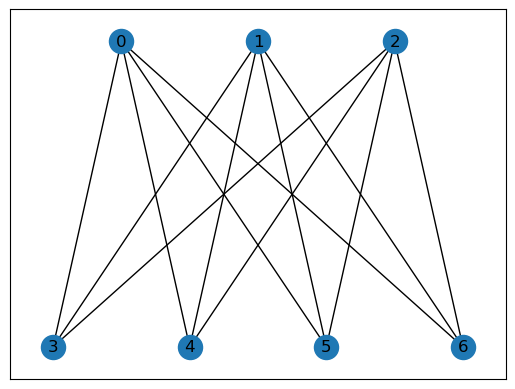

In [61]:
prep = Preprocessing_Graph(Biparti34)
nx.draw_networkx(Biparti34,pos = pos_bip34)

In [62]:
dags,tables,table_departs_arrivees,table_departs,nb_chemins = prep
table_departs_arrivees[0]

array([ 1.,  5.,  9., 10., 11., 12., 13.])

In [63]:
table_departs

array([13., 26., 39., 52., 65., 78., 91.])

In [16]:
nb_chemins

91

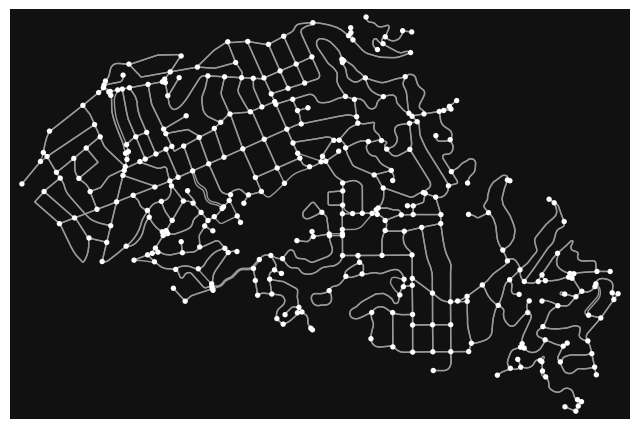

Nombre de plus courts chemins : 620035


In [64]:
piedmont = Preprocessing_Graph(Piedmont)
fig, ax = ox.plot_graph(ox.project_graph(Piedmont))
print(f"Nombre de plus courts chemins : {piedmont[4]}")

### Génération

In [13]:
def Unranking_PCC_depart_arrivee(preprocessing, depart, arrivee, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ et d'arrivée. Renvoie le plus court chemin entre départ et arrivée de rang 'rang' """

    dags,tables = preprocessing[0],preprocessing[1]

    dag_travail = dags[depart]
    table_travail = tables[depart]

    if table_travail[arrivee] == 0:
        raise Exception("depart et arrivee pas dans la même composante connexe")

    rang_reduit = rang % tables[depart][arrivee]

    chemin = [arrivee]
    noeud_courant = arrivee

    # On reconstruit le chemin de l'arrivée au départ en parcourant les prédecesseurs de proche en proche
    while (noeud_courant != depart):
        i = 0
        pred_courant = dag_travail[noeud_courant][i]

        # On cherche le bon prédecesseur
        while (rang_reduit >= table_travail[pred_courant]):
            rang_reduit = rang_reduit - table_travail[pred_courant]
            i+=1
            pred_courant = dag_travail[noeud_courant][i]

        chemin.append(pred_courant)
        noeud_courant = pred_courant

    chemin.reverse()
    return chemin

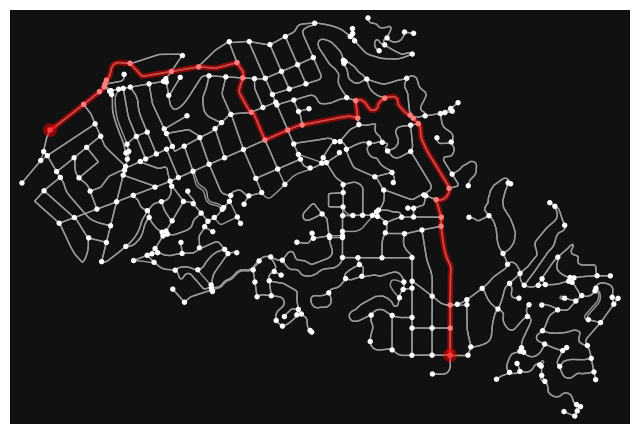

In [66]:
path = Unranking_PCC_depart_arrivee(piedmont, 0, 150, 100)
fig,ax = ox.plot_graph_route(Piedmont, path)

In [14]:
def Unranking_PCC_depart(preprocessing, depart, rang):
    """Prend en argument le preprocessing de la fonction de preprocessing, ainsi qu'un noeud de départ. Renvoie le plus court chemin partant de départ de rang 'rang' """

    table_departs_arrivees = preprocessing[2]
    rang_reduit = rang % int(table_departs_arrivees[depart][-1])

    # On trouve le noeud d'arrivée
    arrivee = recherche_dicho(table_departs_arrivees[depart],rang_reduit)

    return Unranking_PCC_depart_arrivee(preprocessing,depart,arrivee,rang_reduit)

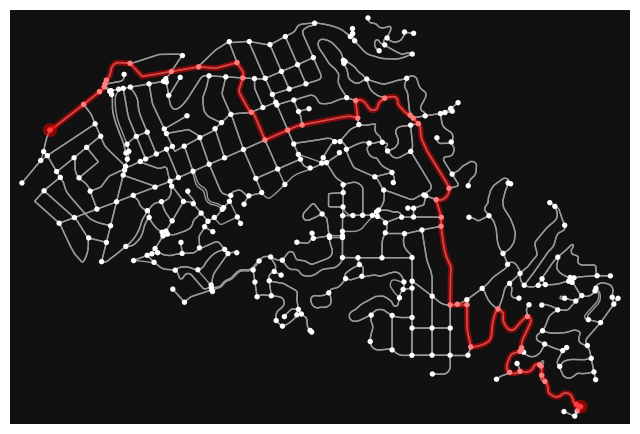

In [69]:
path = Unranking_PCC_depart(piedmont, 0, 100)
fig,ax = ox.plot_graph_route(Piedmont, path)

In [10]:
def Unranking_PCC(preprocessing,rang):
    """Prend en argument le preprocessing de la fonction de preprocessing. Renvoie le plus court chemin de rang 'rang' """

    table_departs,nb_chemins = preprocessing[3],preprocessing[4]
    rang_reduit = rang % nb_chemins

    # On trouve le noeud de départ
    depart = recherche_dicho(table_departs,rang_reduit)

    return Unranking_PCC_depart(preprocessing,depart,rang_reduit)



def Uniforme_PCC(preprocessing):
    """Renvoie un plus court chemin de G avec probabilité uniforme sur tous les plus courts chemins"""
    nb_chemins = preprocessing[4]
    rang = r.randint(0,nb_chemins)

    return Unranking_PCC(preprocessing,rang)

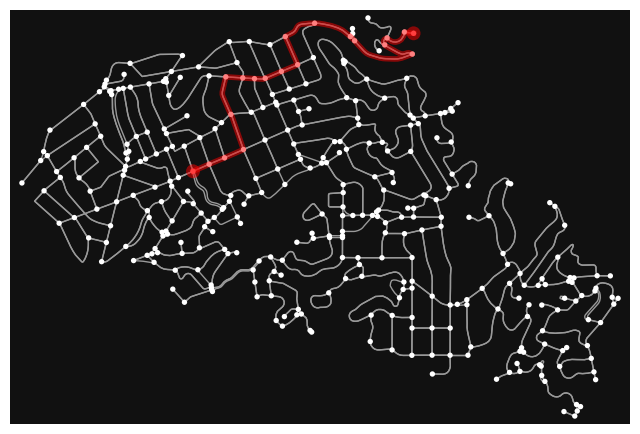

In [71]:
path = Uniforme_PCC(piedmont)
fig,ax = ox.plot_graph_route(Piedmont, path)

# 2. Mesure temporelle

In [7]:
def complexite_generateur_donnees(prepG, nbRequetes = 1000):
    tailles_chemins = []
    temps_generation = []
    for i in range(nbRequetes):
        avant = time.time(); path = Uniforme_PCC(prepG); apres = time.time()
        tailles_chemins.append(len(path))
        temps_generation.append(apres-avant)
    return (tailles_chemins,temps_generation)


def complexite_generateur_points(donnees):
    tailles_chemins,temps_generation = donnees

    plt.clf()
    plt.plot(tailles_chemins,temps_generation,"ob")
    plt.show()
    

def complexite_generateur_moyennes(donnees):
    tailles_chemins,temps_generation = donnees
    tailles = {}
    temps_total = {}
    
    for i in range(len(tailles_chemins)):
        l = tailles_chemins[i]
        tailles[l] = tailles.setdefault(l, 0) + 1
        temps_total[l] = temps_total.setdefault(l,0) + temps_generation[i]
    
    longueurs = []
    temps_moyen = []
    for k in tailles.keys():
        longueurs.append(k)
        temps_moyen.append(temps_total[k]/tailles[k])

    plt.clf()
    plt.plot(longueurs,temps_moyen,"ob")
    plt.show()

In [17]:
G = nx.erdos_renyi_graph(1000,0.003)
prep = Preprocessing_Graph(G)
print(f"Nombre de plus courts chemins : {prep[4]}")

KeyboardInterrupt: 

In [16]:
donnees_gen = complexite_generateur_donnees(prep,nbRequetes = 10000)

Exception: depart et arrivee pas dans la même composante connexe

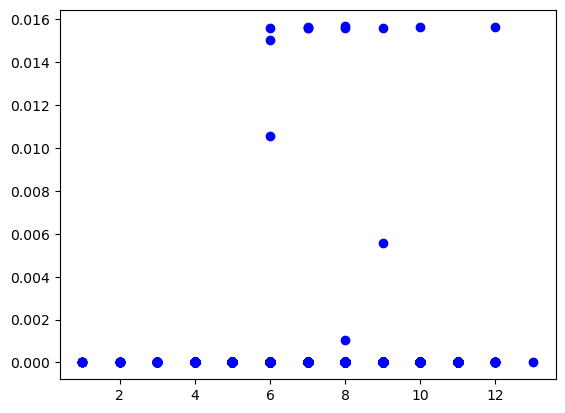

In [38]:
complexite_generateur_points(donnees_gen)

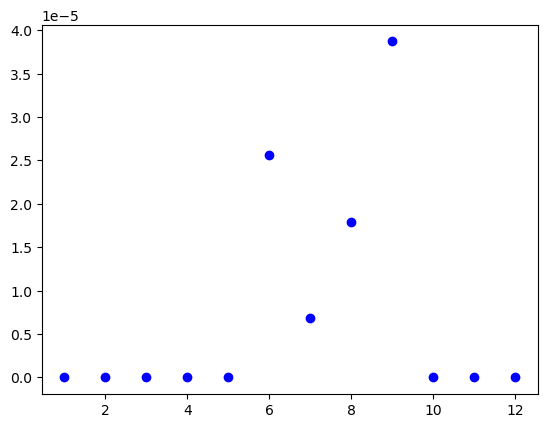

In [55]:
complexite_generateur_moyennes(donnees_gen)

In [18]:
G_reg = nx.random_regular_graph(4,1000)
prep_reg = Preprocessing_Graph(G_reg)
print(f"Nombre de plus courts chemins : {prep_reg[4]}")

Nombre de plus courts chemins : 1808168


In [22]:
donnees_reg = complexite_generateur_donnees(prep_reg,nbRequetes = 10000)

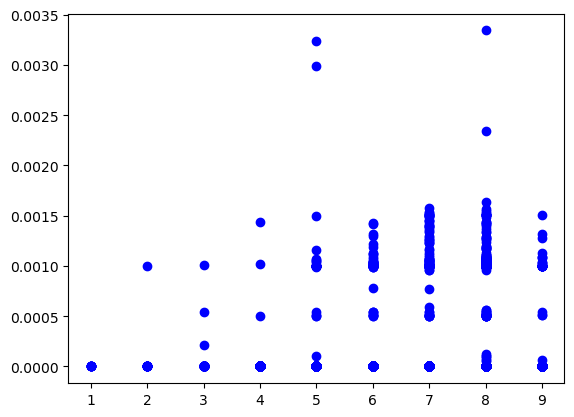

In [20]:
complexite_generateur_points(donnees_reg)

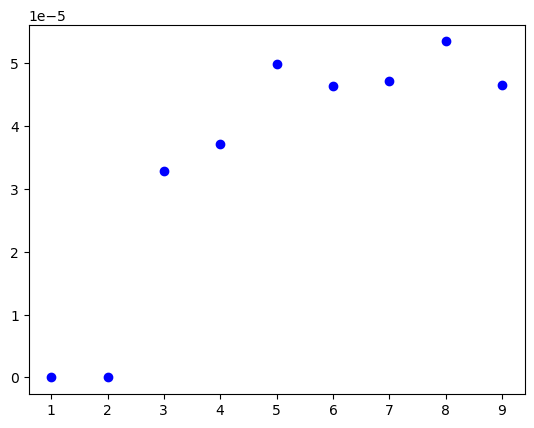

In [23]:
complexite_generateur_moyennes(donnees_reg)